In [1]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import tree

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix

In [2]:
'''
# Cargo de Google Drive los archivos

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id_train_transaction='19setxTbNvfO5L5h-9h5-bcFcl7Ml1kHt'
downloaded = drive.CreateFile({'id': id_train_transaction})
downloaded.GetContentFile('train_transaction.csv')

id_train_identity = '1XUUs36t6K2ByA7xuQuTzRH_smXVtmVjF'
downloaded = drive.CreateFile({'id': id_train_identity})
downloaded.GetContentFile('train_identity.csv')

id_test_transaction='1LnLkTi7YYu95qlR6r7fDGbQUJrNR2uYE'
downloaded = drive.CreateFile({'id': id_test_transaction})
downloaded.GetContentFile('test_transaction.csv')

id_test_identity = '1Pro4HlgAnTo2UmGhS7NReITPAJxxPolA'
downloaded = drive.CreateFile({'id': id_test_identity})
downloaded.GetContentFile('test_identity.csv')'''

"\n# Cargo de Google Drive los archivos\n\nfrom pydrive.auth import GoogleAuth\nfrom pydrive.drive import GoogleDrive\nfrom google.colab import auth\nfrom oauth2client.client import GoogleCredentials\n\n\nauth.authenticate_user()\ngauth = GoogleAuth()\ngauth.credentials = GoogleCredentials.get_application_default()\ndrive = GoogleDrive(gauth)\n\nid_train_transaction='19setxTbNvfO5L5h-9h5-bcFcl7Ml1kHt'\ndownloaded = drive.CreateFile({'id': id_train_transaction})\ndownloaded.GetContentFile('train_transaction.csv')\n\nid_train_identity = '1XUUs36t6K2ByA7xuQuTzRH_smXVtmVjF'\ndownloaded = drive.CreateFile({'id': id_train_identity})\ndownloaded.GetContentFile('train_identity.csv')\n\nid_test_transaction='1LnLkTi7YYu95qlR6r7fDGbQUJrNR2uYE'\ndownloaded = drive.CreateFile({'id': id_test_transaction})\ndownloaded.GetContentFile('test_transaction.csv')\n\nid_test_identity = '1Pro4HlgAnTo2UmGhS7NReITPAJxxPolA'\ndownloaded = drive.CreateFile({'id': id_test_identity})\ndownloaded.GetContentFile('tes

In [3]:
train_identity = pd.read_csv('./ieee-fraud-detection/train_identity.csv')

train_transaction = pd.read_csv('./ieee-fraud-detection/train_transaction.csv')

# Analizo los datasets

Creo los datasets encodeardos, limpios y escalados que voy a utilizar para entrenar y validar el modelo.

In [4]:
train_identity

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,3577521,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 66.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,F3111 Build/33.3.A.1.97
144229,3577526,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN,NaN,...,chrome 55.0 for android,32.0,855x480,match_status:2,T,F,T,F,mobile,A574BL Build/NMF26F
144230,3577529,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN,NaN,...,chrome 65.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,Moto E (4) Plus Build/NMA26.42-152
144231,3577531,-5.0,55528.0,0.0,0.0,0.0,-7.0,NaN,NaN,0.0,...,chrome 66.0,24.0,2560x1600,match_status:2,T,F,T,F,desktop,MacOS


In [5]:
train_transaction

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> ***Observo que train_transaction tiene una columna de TransactionDT.***



Esta es una columna es de tipo datetime y representa el tiempo transcurrido desde un instante de referencia (desconocido). 

Esto significa que debe permanecer ordenada para evitar time-travel. 

In [6]:
# Verifico que esten ordenado los registros en el tiempo

list(train_transaction.TransactionDT) == sorted(train_transaction.TransactionDT, reverse=False)

True

## Busco el dataset completo con el que voy a trabajar

Uno los data sets de trainning que nos dan.

In [7]:
all_data = train_transaction.merge(train_identity, on='TransactionID', how='outer')

In [8]:
import gc

# Libero memoria del sistema
del(train_transaction)
del(train_identity)

# using the garbage collector to manually collect the garbage
gc.collect()

20

Este truco lo saque de Kaggle para administrar la memoria.

In [9]:
display(all_data)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Verifico que mantenga el orden segun TransactionDT

In [10]:
all_data.TransactionDT.hasnans

False

In [11]:
list(all_data.TransactionDT) == sorted(all_data.TransactionDT, reverse=False)

True

## Tomo 80 columnas del DataSet

Segun el modelo baseline de Regresion Logistica, tomo las 80 features mas importantes

In [12]:
top80features = ['C14',
 'C2',
 'C11',
 'C13',
 'C7',
 'C3',
 'V192',
 'V222',
 'V179',
 'DeviceType',
 'V207',
 'V221',
 'C5',
 'V73',
 'V259',
 'V48',
 'M7',
 'V227',
 'V267',
 'card6',
 'V269',
 'V189',
 'V49',
 'ProductCD',
 'V147',
 'M1',
 'V18',
 'V257',
 'V200',
 'id_15',
 'V50',
 'V171',
 'V149',
 'V139',
 'D8',
 'id_29',
 'V208',
 'V323',
 'C8',
 'V182',
 'V210',
 'D3',
 'M6',
 'V188',
 'V229',
 'V33',
 'V71',
 'V285',
 'V153',
 'V58',
 'id_17',
 'V44',
 'TransactionDT',
 'M8',
 'V268',
 'V29',
 'V246',
 'M4',
 'V13',
 'V255',
 'V174',
 'V195',
 'M3',
 'V82',
 'V21',
 'V185',
 'V203',
 'V83',
 'V184',
 'V176',
 'id_36',
 'V294',
 'V168',
 'V332',
 'V175',
 'V333',
 'V225',
 'id_35',
 'V292',
 'V326']

In [13]:
features_adicionales = ['id_31', 'id_33', 'DeviceType', 'DeviceInfo', 'isFraud', 'TransactionDT' ]

for feat in features_adicionales:
    if (not feat in top80features):
        top80features.append(feat)

In [14]:
all_data = all_data[top80features]

display(all_data)

,C14,C2,C11,C13,C7,C3,V192,V222,V179,DeviceType,...,V175,V333,V225,id_35,V292,V326,id_31,id_33,DeviceInfo,isFraud
0,1.0,1.0,2.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0
1,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0
2,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0
3,1.0,5.0,1.0,25.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,mobile,...,0.0,0.0,0.0,T,1.0,0.0,samsung browser 6.2,2220x1080,SAMSUNG SM-G892A Build/NRD90M,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,2.0,1.0,1.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0
590536,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0
590537,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0
590538,1.0,1.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0


## Extraigo los target y features del dataset y creo los sets de trainning y testing.

Creo `data_train` y `data_test` para el set de `data` y

`label_train`, `label_test` para el set de `target`.

> Nota: El target es `isFraud`

### Particiono la data como train_set y test_set

Tomo un 20% de la data como `test_set` y el restante para `train_set` del modelo.

Me baso en TransactionDT como separador de registros.

In [15]:
labels = all_data.isFraud

In [16]:
# Tomo el 80% 
ochenta_porciento = int(all_data['TransactionDT'].size * 0.8)

In [17]:
data_train = all_data.iloc[: ochenta_porciento].drop(columns=['isFraud'])

data_validation = all_data.iloc[ochenta_porciento:].drop(columns=['isFraud'])

In [18]:
label_train = labels.iloc[:ochenta_porciento]

label_validation = labels.iloc[ochenta_porciento:]

## Limpio la data

Para los features categoricos reemplazo los 'nans' por 'desconocido' y para los features numericos los reemplazo por su mean de cada columna.

> Nota: Para el validation test reemplazo los nans por los means correspondientes a las columnas del trainning_set.
>
>  No se vuelven a calcular los means por columnas.

In [19]:
# Busco los promedios de cada columna numerica para el trainning_set

mean_values={}

for i in data_train.columns:
  if (str(data_train[i].dtype) != 'object'):
    mean_values[i] = data_train[i].mean()

In [20]:
# Limpio la data

def limpiar_dataset(dataset, mean_values):
  
  for i in dataset.columns:

    if (str(dataset[i].dtype) != 'object'):
      dataset[i].fillna(mean_values[i], inplace=True)
    
    else:
      dataset[i].fillna('desconocido',inplace=True)

In [21]:
limpiar_dataset(data_train, mean_values)
display(data_train)

,C14,C2,C11,C13,C7,C3,V192,V222,V179,DeviceType,...,V332,V175,V333,V225,id_35,V292,V326,id_31,id_33,DeviceInfo
0,1.0,1.0,2.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,112.743224,0.143299,94.211435,0.176914,desconocido,1.0,0.401879,desconocido,desconocido,desconocido
1,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,112.743224,0.143299,94.211435,0.176914,desconocido,1.0,0.401879,desconocido,desconocido,desconocido
2,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,112.743224,0.143299,94.211435,0.176914,desconocido,1.0,0.401879,desconocido,desconocido,desconocido
3,1.0,5.0,1.0,25.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,112.743224,0.143299,94.211435,0.176914,desconocido,1.0,0.401879,desconocido,desconocido,desconocido
4,1.0,1.0,1.0,1.0,0.0,0.0,1.00000,1.000000,0.000000,mobile,...,0.000000,0.000000,0.000000,0.000000,T,1.0,0.000000,samsung browser 6.2,2220x1080,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472427,1.0,2.0,1.0,2.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,112.743224,0.143299,94.211435,0.176914,desconocido,2.0,0.401879,desconocido,desconocido,desconocido
472428,1.0,2.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,112.743224,0.143299,94.211435,0.176914,desconocido,2.0,0.401879,desconocido,desconocido,desconocido
472429,1.0,1.0,1.0,1.0,0.0,0.0,1.00000,1.000000,0.000000,desktop,...,0.000000,0.000000,0.000000,0.000000,T,1.0,0.000000,chrome 65.0,1440x900,MacOS
472430,1.0,1.0,1.0,2.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,112.743224,0.143299,94.211435,0.176914,desconocido,1.0,0.401879,desconocido,desconocido,desconocido


In [22]:
data_validation

,C14,C2,C11,C13,C7,C3,V192,V222,V179,DeviceType,...,V332,V175,V333,V225,id_35,V292,V326,id_31,id_33,DeviceInfo
472432,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,desktop,...,NaN,0.0,NaN,0.0,F,1.0,NaN,chrome 65.0,NaN,NaN
472433,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,mobile,...,NaN,0.0,NaN,0.0,F,1.0,NaN,chrome generic for android,NaN,F3311
472434,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,desktop,...,NaN,0.0,NaN,0.0,F,1.0,NaN,chrome 65.0,NaN,Windows
472435,1.0,2.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,desktop,...,NaN,0.0,NaN,0.0,F,1.0,NaN,chrome 65.0,NaN,Windows
472436,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,desktop,...,0.0,0.0,0.0,0.0,T,1.0,0.0,firefox 59.0,3200x1800,Windows
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,2.0,1.0,1.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
590536,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
590537,1.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
590538,1.0,1.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [23]:
limpiar_dataset(data_validation, mean_values)
display(data_validation)

,C14,C2,C11,C13,C7,C3,V192,V222,V179,DeviceType,...,V332,V175,V333,V225,id_35,V292,V326,id_31,id_33,DeviceInfo
472432,1.0,1.0,1.0,1.0,1.0,0.0,1.00000,1.000000,0.000000,desktop,...,112.743224,0.000000,94.211435,0.000000,F,1.0,0.401879,chrome 65.0,desconocido,desconocido
472433,1.0,1.0,1.0,1.0,1.0,0.0,1.00000,1.000000,0.000000,mobile,...,112.743224,0.000000,94.211435,0.000000,F,1.0,0.401879,chrome generic for android,desconocido,F3311
472434,0.0,1.0,1.0,0.0,1.0,0.0,1.00000,1.000000,0.000000,desktop,...,112.743224,0.000000,94.211435,0.000000,F,1.0,0.401879,chrome 65.0,desconocido,Windows
472435,1.0,2.0,1.0,1.0,1.0,0.0,1.00000,2.000000,0.000000,desktop,...,112.743224,0.000000,94.211435,0.000000,F,1.0,0.401879,chrome 65.0,desconocido,Windows
472436,1.0,1.0,1.0,1.0,0.0,0.0,1.00000,1.000000,0.000000,desktop,...,0.000000,0.000000,0.000000,0.000000,T,1.0,0.000000,firefox 59.0,3200x1800,Windows
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,2.0,1.0,1.0,3.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,112.743224,0.143299,94.211435,0.176914,desconocido,1.0,0.401879,desconocido,desconocido,desconocido
590536,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,112.743224,0.143299,94.211435,0.176914,desconocido,1.0,0.401879,desconocido,desconocido,desconocido
590537,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,112.743224,0.143299,94.211435,0.176914,desconocido,1.0,0.401879,desconocido,desconocido,desconocido
590538,1.0,1.0,1.0,5.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,112.743224,0.143299,94.211435,0.176914,desconocido,1.0,0.401879,desconocido,desconocido,desconocido


In [24]:
data_validation.reset_index(inplace=True, drop=True)
display(data_validation)

,C14,C2,C11,C13,C7,C3,V192,V222,V179,DeviceType,...,V332,V175,V333,V225,id_35,V292,V326,id_31,id_33,DeviceInfo
0,1.0,1.0,1.0,1.0,1.0,0.0,1.00000,1.000000,0.000000,desktop,...,112.743224,0.000000,94.211435,0.000000,F,1.0,0.401879,chrome 65.0,desconocido,desconocido
1,1.0,1.0,1.0,1.0,1.0,0.0,1.00000,1.000000,0.000000,mobile,...,112.743224,0.000000,94.211435,0.000000,F,1.0,0.401879,chrome generic for android,desconocido,F3311
2,0.0,1.0,1.0,0.0,1.0,0.0,1.00000,1.000000,0.000000,desktop,...,112.743224,0.000000,94.211435,0.000000,F,1.0,0.401879,chrome 65.0,desconocido,Windows
3,1.0,2.0,1.0,1.0,1.0,0.0,1.00000,2.000000,0.000000,desktop,...,112.743224,0.000000,94.211435,0.000000,F,1.0,0.401879,chrome 65.0,desconocido,Windows
4,1.0,1.0,1.0,1.0,0.0,0.0,1.00000,1.000000,0.000000,desktop,...,0.000000,0.000000,0.000000,0.000000,T,1.0,0.000000,firefox 59.0,3200x1800,Windows
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118103,2.0,1.0,1.0,3.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,112.743224,0.143299,94.211435,0.176914,desconocido,1.0,0.401879,desconocido,desconocido,desconocido
118104,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,112.743224,0.143299,94.211435,0.176914,desconocido,1.0,0.401879,desconocido,desconocido,desconocido
118105,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,112.743224,0.143299,94.211435,0.176914,desconocido,1.0,0.401879,desconocido,desconocido,desconocido
118106,1.0,1.0,1.0,5.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,112.743224,0.143299,94.211435,0.176914,desconocido,1.0,0.401879,desconocido,desconocido,desconocido


## Limpio algunos features que tienen demasidos valores unicos

Para que el OneHotEncoder no explote, categorizamos algunos features que tienen demasiados valores unicos.

Utilizo CountVectorizer para DeviceInfo, id_31 y id_33 con un maximo de 10 palabras mas comunes

In [25]:
def obtener_columnas_categoricas(data_set):

  columnas_categoricas = []

  for col in data_set.columns:
        if (str(data_set[col].dtype) == 'object'):
            columnas_categoricas.append(col)

  return columnas_categoricas

In [26]:
data_train[obtener_columnas_categoricas(data_train)].nunique()

DeviceType       3
M7               3
card6            5
ProductCD        5
M1               3
id_15            4
id_29            3
M6               3
M8               3
M4               4
M3               3
id_36            3
id_35            3
id_31          111
id_33          213
DeviceInfo    1640
dtype: int64

### ID_31

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

coun_vect_id31 = CountVectorizer(min_df=10, max_features=15, lowercase=True,  stop_words= ['desconocido','11'])

count_vect_id31_entrenado = coun_vect_id31.fit(data_train.id_31)

In [28]:
count_vec_id_31_data_train =   pd.DataFrame(count_vect_id31_entrenado.transform(data_train.id_31).toarray(), columns = coun_vect_id31.get_feature_names())

data_train.drop(columns='id_31',inplace=True)
data_train = pd.concat([data_train, count_vec_id_31_data_train],axis=1)

display(data_train)

/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,C14,C2,C11,C13,C7,C3,V192,V222,V179,DeviceType,...,android,chrome,desktop,edge,firefox,for,generic,ie,mobile,safari
0,1.0,1.0,2.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
3,1.0,5.0,1.0,25.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.00000,1.000000,0.000000,mobile,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472427,1.0,2.0,1.0,2.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
472428,1.0,2.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
472429,1.0,1.0,1.0,1.0,0.0,0.0,1.00000,1.000000,0.000000,desktop,...,0,1,0,0,0,0,0,0,0,0
472430,1.0,1.0,1.0,2.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0


In [29]:
count_vec_id_31_data_validation =   pd.DataFrame(count_vect_id31_entrenado.transform(data_validation.id_31).toarray(), columns = coun_vect_id31.get_feature_names())

data_validation.drop(columns='id_31',inplace=True)
data_validation = pd.concat([data_validation, count_vec_id_31_data_validation],axis=1)

display(data_validation)

/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,C14,C2,C11,C13,C7,C3,V192,V222,V179,DeviceType,...,android,chrome,desktop,edge,firefox,for,generic,ie,mobile,safari
0,1.0,1.0,1.0,1.0,1.0,0.0,1.00000,1.000000,0.000000,desktop,...,0,1,0,0,0,0,0,0,0,0
1,1.0,1.0,1.0,1.0,1.0,0.0,1.00000,1.000000,0.000000,mobile,...,1,1,0,0,0,1,1,0,0,0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.00000,1.000000,0.000000,desktop,...,0,1,0,0,0,0,0,0,0,0
3,1.0,2.0,1.0,1.0,1.0,0.0,1.00000,2.000000,0.000000,desktop,...,0,1,0,0,0,0,0,0,0,0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.00000,1.000000,0.000000,desktop,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118103,2.0,1.0,1.0,3.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
118104,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
118105,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
118106,1.0,1.0,1.0,5.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0


### ID_33

In [30]:
coun_vect_id33 = CountVectorizer(min_df=10, max_features=15,lowercase=True,  stop_words= ['desconocido','11'])

count_vect_id33_entrenado = coun_vect_id33.fit(data_train.id_33)

In [31]:
count_vec_id_33_data_train =   pd.DataFrame(count_vect_id33_entrenado.transform(data_train.id_33).toarray(), columns = coun_vect_id33.get_feature_names())

data_train.drop(columns='id_33',inplace=True)
data_train = pd.concat([data_train, count_vec_id_33_data_train],axis=1)

display(data_train)

/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,C14,C2,C11,C13,C7,C3,V192,V222,V179,DeviceType,...,1440x900,1600x900,1680x1050,1920x1080,2048x1536,2208x1242,2436x1125,2560x1440,2560x1600,2880x1800
0,1.0,1.0,2.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
3,1.0,5.0,1.0,25.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.00000,1.000000,0.000000,mobile,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472427,1.0,2.0,1.0,2.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
472428,1.0,2.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
472429,1.0,1.0,1.0,1.0,0.0,0.0,1.00000,1.000000,0.000000,desktop,...,1,0,0,0,0,0,0,0,0,0
472430,1.0,1.0,1.0,2.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0


In [32]:
count_vec_id_33_data_validation =   pd.DataFrame(count_vect_id33_entrenado.transform(data_validation.id_33).toarray(), columns = coun_vect_id33.get_feature_names())

data_validation.drop(columns='id_33',inplace=True)
data_validation = pd.concat([data_validation, count_vec_id_33_data_validation],axis=1)

display(data_validation)

/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,C14,C2,C11,C13,C7,C3,V192,V222,V179,DeviceType,...,1440x900,1600x900,1680x1050,1920x1080,2048x1536,2208x1242,2436x1125,2560x1440,2560x1600,2880x1800
0,1.0,1.0,1.0,1.0,1.0,0.0,1.00000,1.000000,0.000000,desktop,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,1.0,1.0,1.0,0.0,1.00000,1.000000,0.000000,mobile,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.00000,1.000000,0.000000,desktop,...,0,0,0,0,0,0,0,0,0,0
3,1.0,2.0,1.0,1.0,1.0,0.0,1.00000,2.000000,0.000000,desktop,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.00000,1.000000,0.000000,desktop,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118103,2.0,1.0,1.0,3.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
118104,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
118105,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
118106,1.0,1.0,1.0,5.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0


### DeviceInfo

In [33]:
coun_vect_di = CountVectorizer(min_df=10, max_features=15, lowercase=True, stop_words= ['desconocido','11'])
count_vect_deviceInfo_entrenado = coun_vect_di.fit(data_train.DeviceInfo)

In [34]:
count_vec_id_dI_data_train =   pd.DataFrame(count_vect_deviceInfo_entrenado.transform(data_train.DeviceInfo).toarray(), columns = coun_vect_di.get_feature_names())

data_train.drop(columns='DeviceInfo',inplace=True)
data_train = pd.concat([data_train, count_vec_id_dI_data_train],axis=1)

display(data_train)

/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,C14,C2,C11,C13,C7,C3,V192,V222,V179,DeviceType,...,mmb29k,mmb29m,moto,mra58k,nrd90m,rv,samsung,sm,trident,windows
0,1.0,1.0,2.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
2,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
3,1.0,5.0,1.0,25.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.00000,1.000000,0.000000,mobile,...,0,0,0,0,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472427,1.0,2.0,1.0,2.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
472428,1.0,2.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
472429,1.0,1.0,1.0,1.0,0.0,0.0,1.00000,1.000000,0.000000,desktop,...,0,0,0,0,0,0,0,0,0,0
472430,1.0,1.0,1.0,2.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0


In [35]:
count_vec_id_dI_data_validation =   pd.DataFrame(count_vect_deviceInfo_entrenado.transform(data_validation.DeviceInfo).toarray(), columns = coun_vect_di.get_feature_names())

data_validation.drop(columns='DeviceInfo',inplace=True)
data_validation = pd.concat([data_validation, count_vec_id_dI_data_validation],axis=1)

display(data_validation)

/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,C14,C2,C11,C13,C7,C3,V192,V222,V179,DeviceType,...,mmb29k,mmb29m,moto,mra58k,nrd90m,rv,samsung,sm,trident,windows
0,1.0,1.0,1.0,1.0,1.0,0.0,1.00000,1.000000,0.000000,desktop,...,0,0,0,0,0,0,0,0,0,0
1,1.0,1.0,1.0,1.0,1.0,0.0,1.00000,1.000000,0.000000,mobile,...,0,0,0,0,0,0,0,0,0,0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.00000,1.000000,0.000000,desktop,...,0,0,0,0,0,0,0,0,0,1
3,1.0,2.0,1.0,1.0,1.0,0.0,1.00000,2.000000,0.000000,desktop,...,0,0,0,0,0,0,0,0,0,1
4,1.0,1.0,1.0,1.0,0.0,0.0,1.00000,1.000000,0.000000,desktop,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118103,2.0,1.0,1.0,3.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
118104,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
118105,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0
118106,1.0,1.0,1.0,5.0,0.0,0.0,1.25468,1.367039,0.536537,desconocido,...,0,0,0,0,0,0,0,0,0,0


In [36]:
data_validation[obtener_columnas_categoricas(data_validation)].nunique()

DeviceType    3
M7            3
card6         3
ProductCD     5
M1            3
id_15         4
id_29         3
M6            3
M8            3
M4            4
M3            3
id_36         3
id_35         3
dtype: int64

In [37]:
data_train[obtener_columnas_categoricas(data_train)].nunique()

DeviceType    3
M7            3
card6         5
ProductCD     5
M1            3
id_15         4
id_29         3
M6            3
M8            3
M4            4
M3            3
id_36         3
id_35         3
dtype: int64

## Aplico OneHot Encoding a data_train y luego a validation_train

Guardo los encodings para los features categoricos en un diccionario para luego asignarselos al set de test.

In [38]:
from sklearn.preprocessing import OneHotEncoder

onehotEncoder = OneHotEncoder(categories='auto', handle_unknown='ignore')
onehotEncoder.fit(data_train[obtener_columnas_categoricas(data_train)])

OneHotEncoder(handle_unknown='ignore')

In [39]:
# Aplico el encoder al data_validation
data_train_cat_onehot = pd.DataFrame(onehotEncoder.transform(data_train[obtener_columnas_categoricas(data_train)]).toarray())

data_train.drop(columns=obtener_columnas_categoricas(data_train),inplace=True)

data_train = pd.concat([data_train, data_train_cat_onehot],axis=1)

display(data_train)

,C14,C2,C11,C13,C7,C3,V192,V222,V179,V207,...,35,36,37,38,39,40,41,42,43,44
0,1.0,1.0,2.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,73.724239,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,73.724239,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,73.724239,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,5.0,1.0,25.0,0.0,0.0,1.25468,1.367039,0.536537,73.724239,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.00000,1.000000,0.000000,0.000000,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472427,1.0,2.0,1.0,2.0,0.0,0.0,1.25468,1.367039,0.536537,73.724239,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
472428,1.0,2.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,73.724239,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
472429,1.0,1.0,1.0,1.0,0.0,0.0,1.00000,1.000000,0.000000,0.000000,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
472430,1.0,1.0,1.0,2.0,0.0,0.0,1.25468,1.367039,0.536537,73.724239,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [40]:
# Aplico el encoder al data_validation
data_validation_cat_onehot = pd.DataFrame(onehotEncoder.transform(data_validation[obtener_columnas_categoricas(data_validation)]).toarray())

data_validation.drop(columns=obtener_columnas_categoricas(data_validation),inplace=True)

data_validation = pd.concat([data_validation, data_validation_cat_onehot],axis=1)

display(data_validation)

,C14,C2,C11,C13,C7,C3,V192,V222,V179,V207,...,35,36,37,38,39,40,41,42,43,44
0,1.0,1.0,1.0,1.0,1.0,0.0,1.00000,1.000000,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,0.0,1.00000,1.000000,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,1.00000,1.000000,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.0,2.0,1.0,1.0,1.0,0.0,1.00000,2.000000,0.000000,0.000000,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0.0,0.0,1.00000,1.000000,0.000000,0.000000,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118103,2.0,1.0,1.0,3.0,0.0,0.0,1.25468,1.367039,0.536537,73.724239,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
118104,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,73.724239,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
118105,1.0,1.0,1.0,1.0,0.0,0.0,1.25468,1.367039,0.536537,73.724239,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
118106,1.0,1.0,1.0,5.0,0.0,0.0,1.25468,1.367039,0.536537,73.724239,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## Aplico feature scalling para obtener mejor modelo

In [41]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(data_train)

data_train = scaler.transform(data_train)
data_validation = scaler.transform(data_validation)

/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [42]:
data_train

array([[-0.14463252, -0.09194727, -0.08779727, ..., -0.35033075,
        -0.40351415,  0.5763335 ],
       [-0.14463252, -0.09194727, -0.09751498, ..., -0.35033075,
        -0.40351415,  0.5763335 ],
       [-0.14463252, -0.09194727, -0.09751498, ..., -0.35033075,
        -0.40351415,  0.5763335 ],
       ...,
       [-0.14463252, -0.09194727, -0.09751498, ..., -0.35033075,
         2.47822785, -1.73510651],
       [-0.14463252, -0.09194727, -0.09751498, ..., -0.35033075,
        -0.40351415,  0.5763335 ],
       [-0.14463252, -0.09194727, -0.09751498, ..., -0.35033075,
        -0.40351415,  0.5763335 ]])

# Creo el Modelo de Random Forest y lo entreno

Teniendo la data ordenada, creo el modelo de Random Forest y lo entreno con `data_train` y `label_train`

Hiper Parametros adicionales que se dejan con su valor default

* bootstrap: True
* min_samples_leaf: 1
* min_samples_split: 2

In [43]:
model = RandomForestRegressor(random_state=1, n_jobs=-1, n_estimators=5,max_features=10, max_depth=10,
                              bootstrap=True, min_samples_leaf=1, min_samples_split=2)

In [44]:
model.fit(data_train, label_train)

RandomForestRegressor(max_depth=10, max_features=10, n_estimators=5, n_jobs=-1,
                      random_state=1)

# Metricas

## Aucroc Score

In [45]:
roc_auc_score(label_train, model.predict(data_train))

0.8665718224793693

In [46]:
roc_auc_score(label_validation, model.predict(data_validation))

0.8325781243742918

# Busqueda de Hiper-parametros

Busco hiper-parametros para `RandomForest` utilizando `GridSearchCV`

Hiper Parametros de RandomForest

*   *n_estimators*: cantidad de árboles a construir (100)
*   *max_depth*: máxima profundidad de cada árbol
*   *min_samples_split*: la cantidad mínima de datos requeridos para splitear un nodo interno (2)
*   *min_samples_leaf*: cantidad mínima de datos requeridos para ser una hoja (1)
*   *max_features*: la cantidad de features a considerar cuando se busca el mejor split (n)

In [47]:
from scipy.stats import uniform
from sklearn.model_selection import GridSearchCV

In [48]:
hiper_parametros = dict(n_estimators=[3,5,8],
                        max_depth=[5,10,15],
                        max_features=[4,6,10],
                        min_samples_split=[2,3],
                        min_samples_leaf=[1,2],
                        bootstrap=[True,False]
                       )

In [49]:
gridSearch = GridSearchCV(model, hiper_parametros, cv=5, n_jobs=-1, scoring='roc_auc')

In [50]:
search = gridSearch.fit(data_train, label_train)

## Busco los mejores parametros

In [51]:
search.best_params_

{'bootstrap': False,
 'max_depth': 15,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 8}

In [52]:
search.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=15, max_features=10,
                      min_samples_split=3, n_estimators=8, n_jobs=-1,
                      random_state=1)

# RandomForest con los mejores hiper-parametros obtenidos 

Usando RandomForest obtengo como Hiper-Parametros obtenidos



| Hiper-Parametro   |  Mejor Valor |  
|:---:|:---:|
| bootstrap    |  False    |
|  max_depth | 15  |  
|  max_features |  10  |
|  n_estimators |  8  |
|  min_samples_leaf   |  1  |
|  min_samples_split   |   2   |

> Nota: El gridSearch hecho no es completamente representativo ya que RandomFoirest es muy pesado como para correr muchas pruebas, por eso los hiperparametros no cambian demasiado con respecto a los originalmente tomados.


Vuelvo a plantear RandomForest para ver como mejora el modelo.

In [53]:
model = search.best_estimator_

model.fit(data_train, label_train)

RandomForestRegressor(bootstrap=False, max_depth=15, max_features=10,
                      min_samples_split=3, n_estimators=8, n_jobs=-1,
                      random_state=1)

## Guardo el modelo final

In [54]:
import joblib

joblib.dump(model, "random_forest_model.pkl")

['random_forest_model.pkl']

In [55]:
roc_auc_score(label_train, model.predict(data_train))

0.9030291564173638

In [56]:
roc_auc_score(label_validation, model.predict(data_validation))

0.8475193428848572

# Score en la competencia

Al comparar con XGBoost, se observa que RandomForest tiene una auc_roc score con el validation set de 0.847, mientras que XGBoost nos dio un score de xxx. 

Por lo tanto determino el valor que tiene en la competencia, por tratarse del mejor modelo entre los dos.

## Cargo los archivos de testing

In [60]:
test_identity = pd.read_csv('./ieee-fraud-detection/test_identity.csv')
test_transaction = pd.read_csv('./ieee-fraud-detection/test_transaction.csv')

In [61]:
test_identity.columns = test_identity.columns.str.replace('id-','id_')

In [62]:
test_data = test_transaction.merge(test_identity, on='TransactionID', how='outer')

del(test_identity)
del(test_transaction)

gc.collect()

501

In [63]:
# Verifico que este ordenada
list(test_data.TransactionDT) == sorted(test_data.TransactionDT, reverse=False)

True

## Tomo las features de interes

In [64]:
transactionID = test_data.TransactionID
top80features.remove('isFraud')
test_data = test_data[top80features]

## Limpio la data

In [65]:
limpiar_dataset(test_data, mean_values)

## Aplico vectorizer

In [66]:
count_vec_id_31_test_set =   pd.DataFrame(count_vect_id31_entrenado.transform(test_data.id_31).toarray(), columns = coun_vect_id31.get_feature_names())
count_vec_id_33_test_set =   pd.DataFrame(count_vect_id33_entrenado.transform(test_data.id_33).toarray(), columns = coun_vect_id33.get_feature_names())
count_vec_id_dI_test_set =   pd.DataFrame(count_vect_deviceInfo_entrenado.transform(test_data.DeviceInfo).toarray(), columns = coun_vect_di.get_feature_names())

/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [70]:
test_data.drop(columns=['id_31','id_33','DeviceInfo'],inplace=True)

test_data = pd.concat([test_data, count_vec_id_31_test_set],axis=1)
test_data = pd.concat([test_data, count_vec_id_33_test_set],axis=1)
test_data = pd.concat([test_data, count_vec_id_dI_test_set],axis=1)

## Aplico OneHot Encoding

In [71]:

test_data_cat_onehot = pd.DataFrame(onehotEncoder.transform(test_data[obtener_columnas_categoricas(test_data)]).toarray())

test_data.drop(columns=obtener_columnas_categoricas(test_data),inplace=True)

test_data = pd.concat([test_data, test_data_cat_onehot],axis=1)

In [72]:
test_data_cat_onehot

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
506687,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
506688,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
506689,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


## Aplico scaler

In [73]:
test_data = scaler.transform(test_data)

/home/paredesj/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


## Hago las predicciones

In [75]:
predictions = model.predict(test_data)

In [77]:
sample_submition = pd.DataFrame()
sample_submition['TransactionID'] = list(transactionID)
sample_submition['isFraud'] = predictions

sample_submition.set_index('TransactionID', inplace=True)
display(sample_submition)

,isFraud
TransactionID,
3663549,0.003495
3663550,0.021354
3663551,0.023769
3663552,0.004624
3663553,0.009865
...,...
4170235,0.020876
4170236,0.021233
4170237,0.014369


In [78]:
sample_submition.to_csv('sample_submition_RF.csv')

## Conclusion

El auc_score obtenido de la competencia es de `0.857682`. Es una mejora del modelo de Linear Regression el cual dio 0.857682

# Puntos Extra

Dibujar la matriz de confusion.

Grafico la matrix de confusion usando las predicciones hechas para el label

In [88]:
def prediccion_binaria(x):
    return 1 if x > 0.5 else 0

predicciones_validation_set = [ prediccion_binaria(x) for x in model.predict(data_validation)  ]

predicciones_trainning_set = [ prediccion_binaria(x) for x in model.predict(data_train)  ]

## Confusion Matrix para set de entrenamiento

In [89]:
accuracy_score(predicciones_trainning_set , label_train)

0.9774549564805094

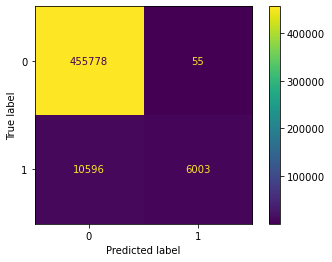

In [90]:
ConfusionMatrixDisplay( confusion_matrix(label_train, predicciones_trainning_set) ).plot()

## Confusion Matrix para set de validacion

In [91]:
accuracy_score(predicciones_validation_set , label_validation)

0.9694262878043824

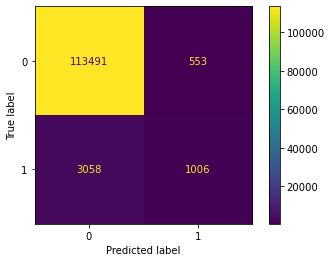

In [92]:
ConfusionMatrixDisplay(confusion_matrix(label_validation, predicciones_validation_set)).plot()

## Conclusion

Observamos que en ambos casos se estima que tenemos un problema desequilibrado en donde la mayoria de la data corresponde a 'no es fraude', lo cual nos da cierta seguridad de que el modelo es consistente.